In [169]:
import pandas as pd
import numpy as np
from collections import Counter

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim71

In [4]:
inputfile = "/home/francisco/GitHub/DQN-Event-Summarization/data/cnn_tokenized/cnn_data_corpus.csv"
inputdict = "/home/francisco/GitHub/DQN-Event-Summarization/data/cnn_tokenized/cnn_total_corpus_smry.csv"

In [3]:
torch.manual_seed(1)

In [5]:
qdf = pd.read_csv(inputfile)
qdict = pd.read_csv(inputdict)

/home/francisco/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
queries = qdf['query_id']
sentences = qdf[[x for x in qdf.columns if 'stokens_' in x]]

true_summaries = {}
for queryid, true_summary in zip(queries, qdf['tstokens']):
    true_summaries[queryid] = Counter([int(x) for x in true_summary.split(" ")])

In [7]:
def rougueScores(genSummary, refSummary):
    genTotal, refTotal, intersection = 0, 0, 0
    for token in list(set(list(refSummary.keys()) + list(genSummary.keys()) )):
        intersection += min(refSummary[token], genSummary[token])
        refTotal += refSummary[token]
        genTotal += genSummary[token]

    recall = intersection / float(refTotal) if float(refTotal) > 0 else 0
    prec   = intersection / float(genTotal) if float(genTotal) > 0 else 0
    f1 = (2 * recall * prec) / (recall + prec) if (recall + prec) > 0 else 0
    
    return recall, prec, f1

In [8]:
sentences[sentences.columns[3]].head()

0    68 69 70 71 72 0 73 74 75 76 77 15 78 79 80 81...
1    394 84 570 574 56 105 558 20001 74 575 271 15 ...
2    8 822 68 110 339 823 824 37 825 826 827 110 78...
3    1194 1195 507 9 551 1196 1188 1197 430 8 37 11...
4    37 574 56 869 8 578 3 579 580 1399 15 90 7 140...
Name: stokens_3, dtype: object

In [9]:
sentence_dict = {}
for sentence in sentences.columns:
    tmp = {}
    for queryid in queries:
        if queryid < 83566:
            if type(sentences[sentence][queryid]) == str:
                tmp[queryid] = [int(s) for s in sentences[sentence][queryid].split(" ")]

    sentence_dict[int(sentence.replace("stokens_", ""))] = tmp

In [16]:
print(tmp)

{76487: [62, 192, 20001, 110, 828, 2488, 103, 1585, 5397, 20001, 884, 17487, 2132]}


In [17]:
trueSummary = Counter([1, 1, 1, 2, 2, 2, 2, 3, 3])

predSummary0 = Counter([1, 1, 1, 2, 2, 2, 2, 3, 3])

predSummary1 = Counter([1, 1, 1, 2, 2, 2, 2, 3, 3, 4])

predSummary2 = Counter([1, 1, 1, 2, 2, 2, 2, 3])

predSummary3 = Counter([4])

In [18]:
print(rougueScores(predSummary0, trueSummary))
print(rougueScores(predSummary1, trueSummary))
print(rougueScores(predSummary2, trueSummary))
print(rougueScores(predSummary3, trueSummary))

(1.0, 1.0, 1.0)
(1.0, 0.9, 0.9473684210526316)
(0.8888888888888888, 1.0, 0.9411764705882353)
(0.0, 0.0, 0)


In [19]:
qdict.head()

,id,token,frequency,cumfreq,percent,cumpercent
0,40,by,4528679,4528679,0.007296,0.007296
1,17,try,4088095,8616774,0.006586,0.013882
2,9,once,3899082,12515856,0.006282,0.020163
3,114,case,3867709,16383565,0.006231,0.026394
4,3,45,3694710,20078275,0.005952,0.032347


In [20]:
corpus_dict = dict(zip(qdict['id'].values, qdict['token'].values))

In [21]:
def make_bow_vector(sentence, word_to_ix):
    vec = torch.zeros(len(word_to_ix))
    for token in sentence:
        vec[token] += 1
    return vec.view(1, -1)

In [121]:
class BoWRegressor(nn.Module):  # inheriting from nn.Module!
    # calls the init function of nn.Module.  Dont get confused by syntax, always do it in an nn.Module
    def __init__(self, outputsize, vocab_size):        
        super(BoWRegressor, self).__init__()        
        self.linear = nn.Linear(vocab_size, outputsize)
        
    def forward(self, bow_vec):
        return F.relu(self.linear(bow_vec))

def make_target(label, label_to_ix):
    return torch.LongTensor([label_to_ix[label]])

In [132]:
train_data = [
    (make_bow_vector([int(s) for s in sentences['stokens_0'][0].split(" ")], corpus_dict),
    torch.LongTensor([0]))
]

n = 10
train_xs = torch.zeros(n, len(corpus_dict))
# Simulating output
train_ys = torch.from_numpy(np.random.random((n, 2))).float()
for i, row in enumerate(sentences['stokens_0']):
    tokens = row.split(" ")
    if len(tokens) > 0 and i < n:
        train_xs[i, :] = make_bow_vector([int(s) for s in tokens], corpus_dict)

In [108]:
print([int(s) for s in sentences['stokens_0'][0].split(" ") ])
print([corpus_dict[int(w)] for w in sentences['stokens_0'][0].split(" ") if int(w) in corpus_dict])

[0, 1, 2, 3, 4, 5, 6, 7]
['i', 'm', '45', 'and', 'my', 'son', 'is']


In [110]:
print(train_xs[0].sum(), train_xs[1].sum(), train_xs.sum())

8.0 21.0 203.0


In [200]:
outputsize = 2 
vocab_size = len(corpus_dict)
model = BoWRegressor(outputsize, vocab_size)

In [202]:
rougue_preds = model(autograd.Variable(train_xs))
print(rougue_preds)

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  0.0000  0.9912
  0.0000  0.8425
  0.0000  0.0000
  0.5767  1.6708
  1.0358  0.4835
  1.2015  0.3555
  0.9197  1.2931
  0.0379  1.5677
  0.4724  0.1716
[torch.FloatTensor of size 10x2]



In [203]:
model.zero_grad()

loss_function = nn.MSELoss()

rougue_preds = model(autograd.Variable(train_xs))
loss = loss_function(rougue_preds, autograd.Variable(train_ys))

print(
    (( (rougue_preds.data).cpu().numpy() - (autograd.Variable(train_ys).data).cpu().numpy() ) **2 ).mean()
     )
print(loss)

0.402182
Variable containing:
 0.4022
[torch.FloatTensor of size 1]



In [204]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

lossf = {'loss': [], 'epoch': []}
for epoch in range(100):
    model.zero_grad()
    
    rougue_preds = model(autograd.Variable(train_xs))
    loss = loss_function(rougue_preds, autograd.Variable(train_ys))
    loss.backward()
    optimizer.step()
    lossf['loss'].append(loss.data[0])
    lossf['epoch'].append(epoch)
    
perf = pd.DataFrame(lossf)

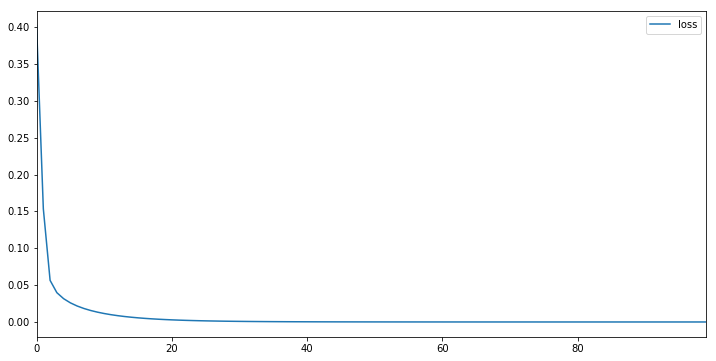

In [212]:
perf.plot(y='loss', figsize=(12, 6))
plt.show()